In [3]:
import pickle
import glob
import os
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import json 
import copy
exp = 'distribution'
train_id_to_cls_name = {}
def read_exp_dir(ds, exp='table'):
    exp_dir = f'/BS/mlcysec2/work/hierarchical-certification/log/{ds}/{exp}'
    
    hierarchy = f'/BS/mlcysec2/work/hierarchical-certification/HRNet-Semantic-Segmentation/data/{ds}/{ds}_hierarchy.json'
    hierarchy = json.load(open(hierarchy, 'r'))
    if ds not in train_id_to_cls_name:
        train_id_to_cls_name[ds] = {}
    for node in hierarchy['nodes']:
        if node['level'] == 0:
            train_id_to_cls_name[ds][node['train_id']] = node['name']
    overall_dict = {}
    for file in tqdm(glob.glob(os.path.join(exp_dir, '*.pkl'))[:100], desc=f'reading from {exp_dir}'):
        d = pickle.load(open(file, 'rb'))
        filename = os.path.basename(file).replace('.pkl', '')
        new_d = {}
        new_d[filename] = d[filename]
        d = new_d
        for image_name, image_d in d.items():
            for model_type, model_d in image_d.items():
                if model_type not in overall_dict:
                    overall_dict[model_type] = {}
                for metric, value in model_d.items():
                    if isinstance(value, dict):
                        for k, v in value.items():
                            if isinstance(v, dict):
                                if metric not in overall_dict[model_type]:
                                    overall_dict[model_type][metric] = {}
                                if k not in overall_dict[model_type][metric]:
                                    overall_dict[model_type][metric][k] = {}
                                for k_, v_ in v.items():
                                    if k_ not in overall_dict[model_type][metric][k]:
                                        overall_dict[model_type][metric][k][k_] = v_
                                    else:
                                        overall_dict[model_type][metric][k][k_] += v_
                            else:
                                if k not in overall_dict[model_type]:
                                    overall_dict[model_type][k] = v
                                else:
                                    overall_dict[model_type][k] += v
                                
                        continue
                    if metric not in overall_dict[model_type]:
                        overall_dict[model_type][metric] = value
                    else:
                        overall_dict[model_type][metric] += value
    return overall_dict

dir_dict = {}
for ds in ['cityscapes', 'acdc', 'cocostuff', 'pascal_ctx']:
    dir_dict[ds] = read_exp_dir(ds, exp=exp)

reading from /BS/mlcysec2/work/hierarchical-certification/log/cityscapes/distribution: 100%|██████████| 100/100 [00:00<00:00, 1132.22it/s]
reading from /BS/mlcysec2/work/hierarchical-certification/log/acdc/distribution: 100%|██████████| 100/100 [00:00<00:00, 1156.47it/s]
reading from /BS/mlcysec2/work/hierarchical-certification/log/cocostuff/distribution:   0%|          | 0/100 [00:00<?, ?it/s]

reading from /BS/mlcysec2/work/hierarchical-certification/log/cocostuff/distribution: 100%|██████████| 100/100 [00:00<00:00, 718.89it/s]
reading from /BS/mlcysec2/work/hierarchical-certification/log/pascal_ctx/distribution: 100%|██████████| 100/100 [00:00<00:00, 1081.81it/s]


In [4]:
col_d = {}

dir_dict_ = copy.deepcopy(dir_dict)
num_classes = { 'cocostuff': 171, 'pascal_ctx': 59, 'cityscapes': 19, 'acdc': 19}
ds_mapper = { 'cocostuff': 'COCO-Stuff-10K', 'pascal_ctx': 'PASCAL-Context', 'cityscapes': 'Cityscapes', 'acdc': 'ACDC'}

for ds, ds_d in dir_dict_.items():
    col_d[ds] = {}
    for model_type, model_d in ds_d.items():
        confusion_matrix = model_d['confusion_matrix']
        pos = confusion_matrix.sum(1)
        res = confusion_matrix.sum(0)
        tp = np.diag(confusion_matrix)
        pixel_acc = tp.sum()/pos.sum()
        mean_acc = (tp/np.maximum(1.0, pos)).mean()
        IoU_array = (tp / np.maximum(1.0, pos + res - tp))
        mean_IoU = IoU_array.mean()
        if isinstance(model_type, tuple):
            n, n0, f, h, sigma, tau = model_type
            if isinstance(f, str):
                col_d[ds] = f
                mean_IoU = '-'
            assert sum(model_d['num_pixels_per_cls']) == model_d['num_pixels']
            dir_dict[ds][model_type]['cCIG'] = [c/n/np.log(num_classes[ds]) for c, n in zip(model_d['cig_per_cls'], model_d['num_pixels_per_cls']) if n > 0]
            dir_dict[ds][model_type]['cPC'] =[c/n for c, n in zip(model_d['certified_per_cls'], model_d['num_pixels_per_cls']) if n > 0]
            dir_dict[ds][model_type]['cabstain'] = [c/n for c, n in zip(model_d['abstain_per_cls'], model_d['num_pixels_per_cls']) if n > 0]
        else:
            model_type = (None, None, None, 0, None, None) 
            dir_dict[ds][model_type] = {'CIG' :pixel_acc,
                                        'cCIG':mean_acc,
                                        'mIoU':mean_IoU,          
                                        'cPC':'-',
                                        'PC':'-',
                                        'cabstain':'-',
                                        'abstain':'-'}

In [110]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import colorcet as cc
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker

font = {'family' : 'serif',
        'size'   : 15}

matplotlib.rc('font', **font)
d = {'segcertify':[], 'adaptivecertify':[]}

def plot_delta_graph(ds, dir_dict, s=90, legend=False, num_cls=5, xtick_spacing=0.05, ytick_spacing=2):
	fig, ax = plt.subplots(1, figsize=(8, 6))
	colors = sns.color_palette(cc.glasbey_dark, n_colors=num_cls)
	ax.set_prop_cycle('color', colors)
	if num_cls == None: num_cls = num_classes[ds]
	s = 90
	for ds_, ds_d in dir_dict.items():
		if ds != ds_: continue
		for model_type, model_d in ds_d.items():
			if isinstance(model_type, tuple): 
				n, n0, f, h, sigma, tau = model_type
				if sigma==0.25 and n == 100 and tau==0.75:
					if f == None: #segcertify
						cig_ls_seg = np.array(dir_dict[ds][model_type]['cCIG'])
						pc_ls_seg = np.array(dir_dict[ds][model_type]['cPC'])
					else: # adaptivecertify
						cig_ls_ada = np.array(dir_dict[ds][model_type]['cCIG'])
						pc_ls_ada = np.array(dir_dict[ds][model_type]['cPC'])
		
		x_axis = cig_ls_ada - cig_ls_seg
  
		y_axis = (pc_ls_ada - pc_ls_seg)*100
		class_labels = np.arange(len(x_axis))
		combined_lists = sorted(zip(x_axis, x_axis, y_axis, class_labels), reverse=True)
		x_axis, _, y_axis, class_labels = map(list, zip(*combined_lists))
		x_mean = np.mean(x_axis)
		y_mean = np.mean(y_axis)
		ax.scatter(x=x_mean, y=y_mean, s=150, label='Overall', marker='X',color='red', edgecolors='black', cmap='viridis')
  
		for i, pt in enumerate(zip(x_axis, y_axis, class_labels)):
			if i > num_cls - 1: break
			xp, yp, i = pt
			if train_id_to_cls_name[ds][i] == 'road': yp=0
			ax.scatter(x=xp, y=yp, s=s, label=train_id_to_cls_name[ds][i], alpha=0.8, cmap='viridis')
		

		ax.xaxis.set_major_locator(ticker.MultipleLocator(xtick_spacing))

		ax.yaxis.set_major_locator(ticker.MultipleLocator(ytick_spacing))

		y_min, y_max = min(y_axis)-3*ytick_spacing, max(y_axis)+ytick_spacing
		ax.set_ylim(y_min, y_max)
		x_min, x_max = min(x_axis)-2*xtick_spacing, max(x_axis)+xtick_spacing
		ax.set_xlim(x_min, x_max)

		plt.gca().spines["top"].set_visible(False)
		plt.gca().spines["right"].set_visible(False)
		plt.gca().spines["left"].set_position(("data", 0))
		plt.gca().spines["bottom"].set_position(("data", 0))

		# ax.set_xlim((min(x_axis)-0.1, max(x_axis)+0.1))
		# ax.set_ylim((min(y_axis)-5, max(y_axis)+1))
		if legend:
			lgnd = ax.legend( loc='upper center', markerscale=2, ncol=4, bbox_to_anchor=(0.5, 0), columnspacing=0.2)
			for handle in lgnd.legendHandles:
				handle.set_sizes([90])
			
		axes_titles = r'  $\Leftrightarrow \Delta \mathrm{CIG}$' +'\n  '
		axes_titles = axes_titles + r'$\Updownarrow \Delta \%$certified'
		ax.text(min(x_axis)-2*xtick_spacing, max(y_axis)+ytick_spacing+2, axes_titles, rotation=0)
		q_color = 'white'
		q_alpha = 0.1
		q_text = r'($+$) $\mathrm{CIG}$' +'\n' + '($+$) $\%$certified'  
		ax.text(x_max-1.4*xtick_spacing, y_max-1.2*ytick_spacing, q_text, fontsize = 10, 
				bbox = dict(facecolor = 'green', alpha = q_alpha), rotation=0)
		q_text = r'($-$) $\mathrm{CIG}$' +'\n' + '($+$) $\%$certified'  
		ax.text(x_min+0.2*xtick_spacing, y_max-1.2*ytick_spacing, q_text, fontsize = 10, 
				bbox = dict(facecolor = q_color, alpha = q_alpha), rotation=0)
		q_text = r'($-$) $\mathrm{CIG}$' +'\n' + '($-$) $\%$certified'  
		ax.text(x_min+0.2*xtick_spacing, y_min+0.9*ytick_spacing, q_text, fontsize = 10, 
				bbox = dict(facecolor = q_color, alpha = q_alpha), rotation=0)
		q_text = r'($+$) $\mathrm{CIG}$' +'\n' + '($-$) $\%$certified'  
		ax.text(x_max-1.4*xtick_spacing, y_min+0.9*ytick_spacing, q_text, fontsize = 10, 
				bbox = dict(facecolor = q_color, alpha = q_alpha), rotation=0)
		# remove 0.00
		ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
		ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
		xticks = ax.get_xticks().tolist()
		xticks = ['{:.2f}'.format(x) if abs(x) > 10e-15  else '' for x in xticks]
		j = ax.set_xticklabels(xticks)
		yticks = ax.get_yticks().tolist()
		yticks = ['{:.0f}'.format(x) if abs(x)  > 10e-15 else '' for x in yticks]
		j = ax.set_yticklabels(yticks)
		fig.text(0.5, 0.95, ds_mapper[ds], fontsize=18, ha='center')
		ax.set_axisbelow(True)
		ax.grid(color='white', linestyle = '-', linewidth = 2, alpha=1, zorder=0)
		ax.set_facecolor('whitesmoke')
		for label in ax.get_xticklabels() + ax.get_yticklabels():
			label.set_zorder(5)  # Set zorder for the tick labels

		plt.savefig(f'/BS/mlcysec2/work/hierarchical-certification/graph_images/delta_{ds}.pdf',  bbox_inches="tight")


/BS/mlcysec2/work/tmp/ipykernel_1740560/2593406617.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x=x_mean, y=y_mean, s=150, label='Overall', marker='X',color='red', edgecolors='black', cmap='viridis')
/BS/mlcysec2/work/tmp/ipykernel_1740560/2593406617.py:48: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x=xp, y=yp, s=s, label=train_id_to_cls_name[ds][i], alpha=0.8, cmap='viridis')
/BS/mlcysec2/work/tmp/ipykernel_1740560/2593406617.py:69: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:
/BS/mlcysec2/work/tmp/ipykernel_1740560/2593406617.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  j = ax.set_xticklabels(xticks)
/BS/mlcysec2/work/tmp/ipykernel_1740560/2593406617.py:97: UserWarning:

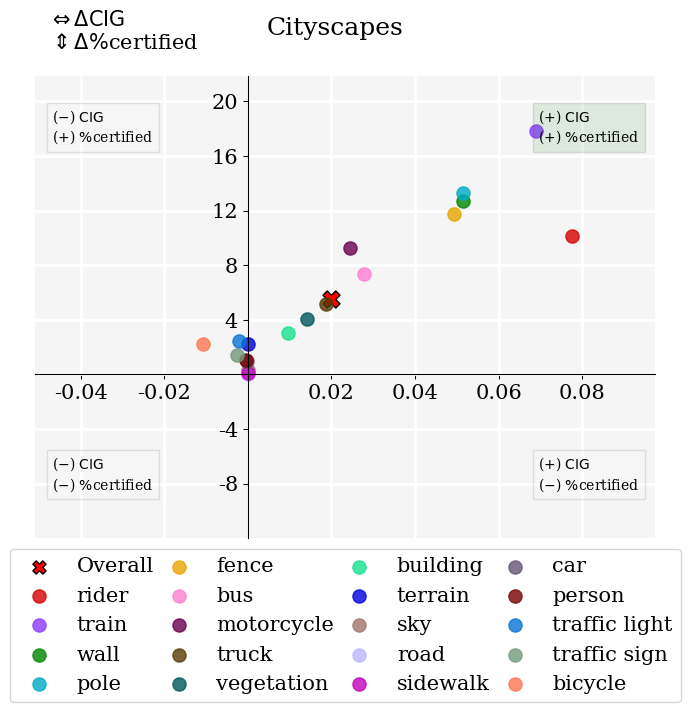

In [112]:
plot_delta_graph('cityscapes', dir_dict, s=90, ytick_spacing=4, xtick_spacing=0.02, legend=True, num_cls=23)